# Practice PS07: Outlier analysis

In this session we will find outliers by implementing the Isolation Forest algorithm.

Author: Tània Pazos Puig

E-mail: tania.pazos01@estudiant.upf.edu

Date: 14/11/2024

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import csv
import io
import random
import numpy as np

# 1. Dataset

We will use the file `annthyroid.csv` that contains data about exams of the thyroid gland of 7,200 patients. In each exam, six attributes *f1*, *f2*, ..., *f6* of each patient are measured. A ground-truth label indicating if the thyroid was finally found to be normal or abnormal is included in the dataset.

In [2]:
# LEAVE AS-IS

df = pd.read_csv('data/annthyroid.csv', sep=',')

# Replace the "label" column by an "abnormal" column
df['result'] = df['label'].apply(lambda x: 'abnormal' if x == 1 else 'normal')
df.drop(columns=['label'], inplace=True)

The code below prints the total number of patients, the number and percentage of patients with a normal thyroid, and the number and percentage of patients with an abnormal thyroid.

In [3]:
total_patients = len(df)

total_patients = len(df)
normal_count = len(df[df['result'] == 'normal'])
abnormal_count = len(df[df['result'] == 'abnormal'])

normal_percentage = (normal_count / total_patients) * 100
abnormal_percentage = (abnormal_count / total_patients) * 100

print(f"Total patients   : {total_patients}")
print(f"Normal thyroid   : {normal_count} ({normal_percentage:.2f}%)")
print(f"Abnormal thyroid : {abnormal_count} ({abnormal_percentage:.2f}%)")

Total patients   : 7200
Normal thyroid   : 6666 (92.58%)
Abnormal thyroid : 534 (7.42%)


Now, we print the 10 normal exams and the centroid of all normal exams, and the first 10 abnormal exams and the centroid of all abnormal exams.

In [4]:
normal_exams = df[df['result'] == 'normal']
abnormal_exams = abnormal_exams = df[df['result'] == 'abnormal']

print("First 10 normal exams:")
print(normal_exams.head(10))

centroid_normal = normal_exams[['f1', 'f2', 'f3', 'f4', 'f5', 'f6']].mean()
print("\nCentroid of normal exams:")
print(centroid_normal)

print("\nFirst 10 abnormal exams:")
print(abnormal_exams.head(10))

centroid_abnormal = abnormal_exams[['f1', 'f2', 'f3', 'f4', 'f5', 'f6']].mean()
print("\nCentroid of abnormal exams:")
print(centroid_abnormal)

First 10 normal exams:
     f1       f2     f3     f4     f5     f6  result
0  0.73  0.00060  0.015  0.120  0.082  0.146  normal
1  0.24  0.00025  0.030  0.143  0.133  0.108  normal
2  0.47  0.00190  0.024  0.102  0.131  0.078  normal
3  0.64  0.00090  0.017  0.077  0.090  0.085  normal
4  0.23  0.00025  0.026  0.139  0.090  0.153  normal
5  0.69  0.00025  0.016  0.086  0.070  0.123  normal
6  0.85  0.00025  0.023  0.128  0.104  0.121  normal
7  0.48  0.00208  0.020  0.086  0.078  0.110  normal
8  0.67  0.00130  0.024  0.087  0.109  0.080  normal
9  0.76  0.00010  0.029  0.124  0.128  0.097  normal

Centroid of normal exams:
f1    0.518314
f2    0.002098
f3    0.020384
f4    0.112193
f5    0.097705
f6    0.116132
dtype: float64

First 10 abnormal exams:
       f1       f2      f3      f4     f5      f6    result
10   0.62  0.01100  0.0080  0.0730  0.074  0.0980  abnormal
19   0.50  0.06100  0.0096  0.0130  0.116  0.0110  abnormal
27   0.78  0.02500  0.0090  0.0500  0.084  0.0600  abnor

Observing the centroids of the normal and abnormal exams, the features `f2`, `f4`, and `f6` could be used to differentiate between normal and abnormal thyroids. Indeed, `f2` is notably higher for abnormal exams (0.039 vs 0.002), while the average of `f4` and `f6` is lower in abnormal exams (0.074 vs 0.112 and 0.076 vs 0.116, respectively). 

The following code creates a scatter matrix, which displays all scatter plots of combinations of two dimensions in the data. The abnormal group is represented in red, whereas the normal data points appear in blue.

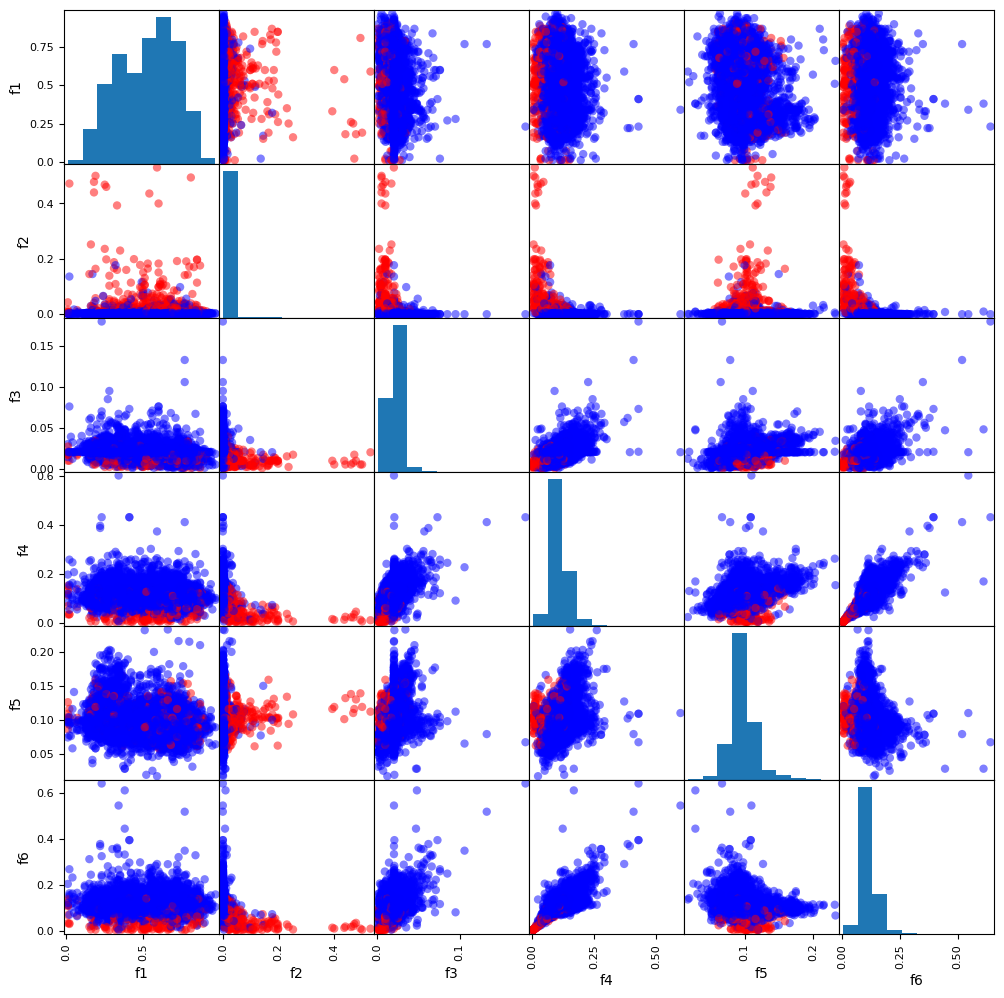

In [5]:
color_code = {'abnormal': 'red', 'normal': 'blue'}
colors = df['result'].apply(lambda x: color_code[x])

# Create a scatter matrix 
pd.plotting.scatter_matrix(df[['f1', 'f2', 'f3', 'f4', 'f5', 'f6']], c=colors, figsize=(12, 12), marker='o', alpha=0.5)

plt.show()

From the scatter matrix, several significant differences can be observed between the normal (blue) and the abnormal (red) exams based on all combinations of features.

Firstly, it should be noted that plots for `f2` against all other features and `f1` against `f3`, `f4` and `f6` show a clear separation between the normal and abnormal data points. This suggests that these feature combinations might be useful for distinguishing between normal and abnormal cases.

Secondly, for `f2` against all other features, it can be seen that normal points are concentrated to the left, whereas abnormal points show a wide spread from left to right (across feature values). However, for features `f4` and `f6` against all other features, abnormal points appear concentrated to left, and in most cases -except for `f1`- abnormal data points occupy lower values vertically.

# 1. Create isolation tree

## 1.1. Random dimension and random split

Now, let us create a function that returns a random dimension in the dataset ignoring columns `id` and `results`.

In [6]:
def pick_random_dimension(df, columns_to_ignore):
    valid_columns = [col for col in df.columns if col not in columns_to_ignore]
    return random.choice(valid_columns)

In [7]:
columns_to_ignore = ['id', 'result']
print("Random dimension (1st call):", pick_random_dimension(df, columns_to_ignore))
print("Random dimension (2nd call):", pick_random_dimension(df, columns_to_ignore))

Random dimension (1st call): f3
Random dimension (2nd call): f1


Next, we implement a function to return a random split point chosen uniformly at random between the minimum and the maximum value along a specified dimension (in our tests, we use `f1`). 

In [8]:
def pick_random_split(df, dimension):
    min_value = np.min(df[dimension])
    max_value = np.max(df[dimension])
    return random.uniform(min_value, max_value)

In [9]:
print("Random split point (1st call):", pick_random_split(df, 'f1'))
print("Random split point (2nd call):", pick_random_split(df, 'f1'))

Random split point (1st call): 0.34857852255006316
Random split point (2nd call): 0.32471712192278973


## 1.2. Implement split data into two

The code below implements a function that returns to sub-datasets: one with all elements having *dimension <= split*, and another one with all elements having *dimension > split*.

In [10]:
def split_dataset(df, dimension, split):
    subset_le = df[df[dimension] <= split]
    subset_gt = df[df[dimension] > split]
    return subset_le, subset_gt

In [11]:
dimension_to_split = 'f1'
split_point = 0.5
subset_le, subset_gt = split_dataset(df, dimension_to_split, split_point)

print("Subset with f1 <= 0.5:")
print(subset_le.head())

print("\nSubset with f1 > 0.5:")
print(subset_gt.head())

Subset with f1 <= 0.5:
      f1       f2     f3     f4     f5     f6  result
1   0.24  0.00025  0.030  0.143  0.133  0.108  normal
2   0.47  0.00190  0.024  0.102  0.131  0.078  normal
4   0.23  0.00025  0.026  0.139  0.090  0.153  normal
7   0.48  0.00208  0.020  0.086  0.078  0.110  normal
11  0.18  0.00010  0.023  0.098  0.085  0.115  normal

Subset with f1 > 0.5:
     f1       f2     f3     f4     f5     f6  result
0  0.73  0.00060  0.015  0.120  0.082  0.146  normal
3  0.64  0.00090  0.017  0.077  0.090  0.085  normal
5  0.69  0.00025  0.016  0.086  0.070  0.123  normal
6  0.85  0.00025  0.023  0.128  0.104  0.121  normal
8  0.67  0.00130  0.024  0.087  0.109  0.080  normal


In [12]:
subset_le_size = len(subset_le)
subset_gt_size = len(subset_gt)
original_size = len(df)

print(f"Size of subset with {dimension_to_split} <= {split_point}: {subset_le_size}")
print(f"Size of subset with {dimension_to_split} > {split_point}: {subset_gt_size}")
print(f"Total size of both subsets: {subset_le_size + subset_gt_size}")
print(f"Original dataset size: {original_size}")

Size of subset with f1 <= 0.5: 3169
Size of subset with f1 > 0.5: 4031
Total size of both subsets: 7200
Original dataset size: 7200


Indeed, the sum of the sizes of the two sub-datasets is the size of the original data.

## 1.3. Create one isolation tree

We will first add a patient identifier in column "id". The new dataframe is called `dfi`.

In [13]:
# LEAVE AS-IS

dfi = df.copy()
dfi.insert(0, 'id', [("P%.4d" % x) for x in range(1, 1 + len(df))])
dfi

,id,f1,f2,f3,f4,f5,f6,result
0,P0001,0.73,0.00060,0.0150,0.120,0.082,0.1460,normal
1,P0002,0.24,0.00025,0.0300,0.143,0.133,0.1080,normal
2,P0003,0.47,0.00190,0.0240,0.102,0.131,0.0780,normal
3,P0004,0.64,0.00090,0.0170,0.077,0.090,0.0850,normal
4,P0005,0.23,0.00025,0.0260,0.139,0.090,0.1530,normal
...,...,...,...,...,...,...,...,...
7195,P7196,0.59,0.00250,0.0208,0.079,0.099,0.0800,normal
7196,P7197,0.51,0.10600,0.0060,0.005,0.089,0.0055,abnormal
7197,P7198,0.51,0.00076,0.0201,0.090,0.067,0.1340,normal
7198,P7199,0.35,0.00280,0.0201,0.090,0.089,0.1010,normal


Next, we define a recursive function `isolation_tree(data, columns_to_ignore, min_items)` to implement an isolation tree.

In [14]:
def isolation_tree(data, columns_to_ignore, min_items):
    tree = {}
    if len(data) <= min_items:
        return {"contents": data}
    else:
        # Pick random dimension
        dimension = pick_random_dimension(data, columns_to_ignore)
        
        # Select random split point along the chosen dimension
        split = pick_random_split(data, dimension)
        
        # Split dataset into two subsets
        subset_le, subset_gt = split_dataset(data, dimension, split)
        
        # Recursively build left and right branches
        tree["left"] = isolation_tree(subset_le, columns_to_ignore, min_items)
        tree["right"] = isolation_tree(subset_gt, columns_to_ignore, min_items)
        tree["dimension"] = dimension
        tree["split"] = split
        
    return tree

We will test our function by creating a shallow tree.

In [15]:
# LEAVE AS-IS

mytree = isolation_tree(dfi, ['id', 'result'], 2000)

Below we provide auxiliary functions to print our tree.

In [16]:
# LEAVE AS-IS

class tree_drawing(object):
    def __init__(self, value, left=None, right=None):
        self.value = value
        self.left = left
        self.right = right

    def __str__(self, label='', level=0):
        ret = "-" * level + label + ":" + repr(self.value)+"\n"
        if self.left:
            ret += self.left.__str__("<", level+1)
        if self.right:
            ret += self.right.__str__(">", level+1)
        return ret

    def __repr__(self):
        return self.value
    
def tree_to_nodes(tree):
    if 'contents' in tree:
        data = tree['contents']
        normal_count = len(data[data['result'] == 'normal'])
        abnormal_count = len(data[data['result'] == 'abnormal'])
        description = "external node: %d normal + %d abnormal" % (normal_count, abnormal_count)
        return tree_drawing(description)
    else:
        left = tree['left']
        right = tree['right']
        description = 'internal node: ' + tree['dimension'] + ' <= ' + ("%.2f" % tree['split'])
        n = tree_drawing(description, tree_to_nodes(left), tree_to_nodes(right) )
        return n

In [17]:
print(tree_to_nodes(mytree))

:'internal node: f1 <= 0.30'
-<:'external node: 1127 normal + 67 abnormal'
->:'internal node: f4 <= 0.24'
--<:'internal node: f2 <= 0.39'
---<:'internal node: f2 <= 0.18'
----<:'internal node: f5 <= 0.06'
-----<:'external node: 116 normal + 6 abnormal'
----->:'internal node: f3 <= 0.04'
------<:'internal node: f3 <= 0.01'
-------<:'external node: 308 normal + 123 abnormal'
------->:'internal node: f1 <= 0.66'
--------<:'internal node: f5 <= 0.10'
---------<:'external node: 1832 normal + 118 abnormal'
--------->:'external node: 1627 normal + 103 abnormal'
-------->:'external node: 1491 normal + 99 abnormal'
------>:'external node: 127 normal + 3 abnormal'
---->:'external node: 1 normal + 10 abnormal'
--->:'external node: 0 normal + 5 abnormal'
-->:'external node: 37 normal + 0 abnormal'



Below we create a function to return the maximum depth of a tree.

In [18]:
def get_max_tree_depth(tree):
    # If node has contents, it is an external node, hence the depth is 0
    if 'contents' in tree:
        return 0
    else:
        # Recursively find the depth of the left and right branches
        left_depth = get_max_tree_depth(tree['left'])
        right_depth = get_max_tree_depth(tree['right'])
        
        # The depth of the current node is the max depth of the branches plus 1
        return 1 + max(left_depth, right_depth)

In [19]:
max_depth = get_max_tree_depth(mytree)
print(f"Maximum tree depth: {max_depth}")

Maximum tree depth: 9


# 2. Create isolation forests and find depth of items

In this section we will implement an isolation forest, which is simply an array of isolation trees.

## 2.1. Create an isolation forest

First, we write a function `isolation_forest(dfi, columns_to_ignore, min_items, num_trees)` to create an array of *num_trees* isolation trees.

In [20]:
def isolation_forest(dfi, columns_to_ignore, min_items, num_trees):
    trees = []
    
    # Create num_trees isolation trees
    for _ in range(num_trees):
        # Sample a random subset of the data to build the tree
        # without replacement
        subset = dfi.sample(frac=1, replace=False)
        
        # Build an isolation tree
        tree = isolation_tree(subset, columns_to_ignore, min_items)
        trees.append(tree)
    
    return trees

We use the next code to test how to create an isolation forest of 30 trees, in which leaves have at least 50 items.

In [21]:
# MODIFY IF YOU SEE THAT IT IMPROVES THE SEPARATION BETWEEN CLASSES

min_items = 50
num_trees = 30

In [22]:
# LEAVE AS-IS

myforest = isolation_forest(dfi, ['id', 'result'], min_items, num_trees)
print("The forest has %d trees" % len(myforest))

The forest has 30 trees


Below we print the first two trees of this forest.

In [23]:
# LEAVE AS-IS

for i in range(0, 2):
    print("Tree number %d" % i)
    print(tree_to_nodes(myforest[i]))
    print()

Tree number 0
:'internal node: f2 <= 0.42'
-<:'internal node: f2 <= 0.30'
--<:'internal node: f5 <= 0.18'
---<:'internal node: f5 <= 0.02'
----<:'external node: 2 normal + 0 abnormal'
---->:'internal node: f2 <= 0.19'
-----<:'internal node: f6 <= 0.03'
------<:'internal node: f3 <= 0.04'
-------<:'internal node: f6 <= 0.03'
--------<:'internal node: f6 <= 0.01'
---------<:'external node: 1 normal + 33 abnormal'
--------->:'external node: 11 normal + 24 abnormal'
-------->:'external node: 2 normal + 10 abnormal'
------->:'external node: 2 normal + 0 abnormal'
------>:'internal node: f5 <= 0.08'
-------<:'internal node: f4 <= 0.09'
--------<:'internal node: f3 <= 0.04'
---------<:'internal node: f4 <= 0.07'
----------<:'internal node: f2 <= 0.05'
-----------<:'internal node: f3 <= 0.01'
------------<:'internal node: f5 <= 0.06'
-------------<:'external node: 30 normal + 3 abnormal'
------------->:'internal node: f2 <= 0.02'
--------------<:'internal node: f4 <= 0.07'
---------------<:'ex

## 2.2. Find the average depth of an item

The provided function `find_element_depth` finds the depth of a given element by recursively traversing the tree.

In [24]:
# LEAVE AS-IS

def find_element_depth_aux(tree, column_name, column_value, depth):
    
    if 'contents' in tree:
        # We are in a leaf node
        
        data = tree['contents']
        matching = data[data[column_name] == column_value]
        if len(matching) == 0:
            return None
        elif len(matching) > 1:
            print("Error: multiple elements match your search criterion")
            return None
        else:
            return depth
    else:
        # We are in an internal node
        
        in_left = find_element_depth_aux(tree['left'], column_name, column_value, depth+1)
        if in_left == None:
            in_right = find_element_depth_aux(tree['right'], column_name, column_value, depth+1)
            return in_right
        else:
            return in_left
        
def find_element_depth(tree, column_name, column_value):
    return find_element_depth_aux(tree, column_name, column_value, 0)

Below, we use the defined functions to find 5 normal and 5 abnormal thyroid exams on the shallow tree `mytree` that we created above, and on the first tree of the forest we created.

In [25]:
# LEAVE AS-IS

def print_sample_depths(df, sample_size, tested_tree):

    for result in ['normal', 'abnormal']:
        print("Depths for %s items" % result)

        sample = list(df[df['result'] == result]['id'].sample(sample_size))

        max_depth = get_max_tree_depth(tested_tree)
        for random_id in sample:
            depth = find_element_depth(tested_tree, "id", random_id)
            if depth is None:
                print("- id=%s not found in the tree" % random_id)
            else:
                print("- id=%s is at depth %d/%d" % (random_id, depth, max_depth))
            
print("On shallow tree, having maximum depth %d" % get_max_tree_depth(mytree))
print_sample_depths(dfi, 5, mytree)
print()

print("On first tree of forest, having maximum depth %d" % get_max_tree_depth(myforest[0]))
print_sample_depths(dfi, 5, myforest[0])
print()

On shallow tree, having maximum depth 9
Depths for normal items
- id=P3070 is at depth 9/9
- id=P3915 is at depth 1/9
- id=P5017 is at depth 9/9
- id=P1123 is at depth 8/9
- id=P6923 is at depth 9/9
Depths for abnormal items
- id=P6669 is at depth 8/9
- id=P4397 is at depth 8/9
- id=P4420 is at depth 7/9
- id=P4715 is at depth 9/9
- id=P7118 is at depth 8/9

On first tree of forest, having maximum depth 38
Depths for normal items
- id=P5740 is at depth 33/38
- id=P5609 is at depth 28/38
- id=P3482 is at depth 23/38
- id=P7171 is at depth 13/38
- id=P5546 is at depth 34/38
Depths for abnormal items
- id=P3518 is at depth 25/38
- id=P5931 is at depth 15/38
- id=P5686 is at depth 9/38
- id=P0936 is at depth 23/38
- id=P4328 is at depth 18/38



On the one hand, the normal items in the shallow tree (with maximum depth 11) are located closer to the root compared to the abnormal items. Indeed, the depth of the normal items range from 1 to 10, whereas the range of depths of abnormal items goes from 6 to 10. This suggests than, in the shallow tree, the model is able to separate outliers from the normal items using a small number of splits. Although outliers are easily isolated, they are not clearly separated from the rest of the data.

However, the difference in depth values between normal and abnormal items becomes clearer in the first tree of the forest (which has maximum depth of 38). In this deeper tree, normal items are located closer to the leaves (at depths 23 to 26), whereas abnormal items are found closer to the root (at depths 6 to 23). This indicates that the first tree in the forest is better at distinguishing between normal and abnormal items than the shallow tree.

The function `find_average_depth(forest, column_name, value)`  finds the the average depth of an element having *column_name = value*

In [26]:
def find_average_depth(forest, column_name, value):
    total_depth = 0
    num_trees = len(forest)
    
    for tree in forest:
        depth = find_element_depth(tree, column_name, value)
        if depth is not None:
            total_depth += depth
        else:
            num_trees -= 1  
    
    # If the element was found in any tree, compute the average depth
    if num_trees > 0:
        average_depth = total_depth / num_trees
        return average_depth
    else:
        print(f"Element with {column_name}={value} not found in any tree.")
        return None

We test this function with five random elements.

In [27]:
# LEAVE AS-IS

for result in ['normal', 'abnormal']:
    print("Average depths for %s items" % result)
    
    sample = list(dfi[dfi['result'] == result]['id'].sample(5))
    
    for random_id in sample:
        print("- id=%s is at average depth %.1f" % (random_id, find_average_depth(myforest, "id", random_id)))
    
    print()

Average depths for normal items
- id=P6565 is at average depth 17.8
- id=P1317 is at average depth 13.9
- id=P6688 is at average depth 17.6
- id=P6074 is at average depth 22.3
- id=P4423 is at average depth 24.1

Average depths for abnormal items
- id=P0921 is at average depth 17.3
- id=P4572 is at average depth 21.8
- id=P5941 is at average depth 11.6
- id=P3597 is at average depth 21.8
- id=P4361 is at average depth 22.2



To improve efficiency when computing the average depth for **all** elements, we would traverse each of the trees of the forest once and collect cumulative depths for all elements in a dictionary `depth_sums`. Similarly, we would also store the number of trees each element appears in a dictionary `depth_counts`. After traversing the entire forest, we would compute the average depth for each element by dividing its total depth in `depth_sums` by the number of trees in which it appears (retrieved from `depth_counts`).

# 3. Find the average depth of a sample of normal and abnormal points

## 3.1. Determine average depths

Next we sample 30 normal and 30 abnormal points, and store their average depths in `myforest` into arrays `normal_depths` and `abnormal_depths`.

In [28]:
# LEAVE AS-IS

abnormal_point_ids = list(dfi[dfi['result'] == 'abnormal']['id'].sample(30))
normal_point_ids = list(dfi[dfi['result'] == 'normal']['id'].sample(30))

print("Normal point sample ids   : %s" % normal_point_ids)
print("Abnormal point sample ids : %s" % abnormal_point_ids)

Normal point sample ids   : ['P0576', 'P7026', 'P3057', 'P3573', 'P1407', 'P0164', 'P4128', 'P3448', 'P5239', 'P0100', 'P3633', 'P3365', 'P6428', 'P6715', 'P0933', 'P6687', 'P2494', 'P3777', 'P6177', 'P5945', 'P0712', 'P5999', 'P0137', 'P6407', 'P3894', 'P3213', 'P6544', 'P4154', 'P6605', 'P1633']
Abnormal point sample ids : ['P1778', 'P2042', 'P3165', 'P5950', 'P0430', 'P2668', 'P5972', 'P5566', 'P6702', 'P3038', 'P1989', 'P2345', 'P6052', 'P0560', 'P0498', 'P2689', 'P5212', 'P2210', 'P3148', 'P3680', 'P0795', 'P1740', 'P5449', 'P1226', 'P3606', 'P1463', 'P4968', 'P0936', 'P0894', 'P1105']


In [29]:
# LEAVE AS-IS

normal_depths = []
print("Depths of items in the 'normal' sample:")
for i in normal_point_ids:
    depth = find_average_depth(myforest, 'id', i)
    normal_depths.append(depth)
    print(" element id=%s is at average depth %.2f" % (i, depth))
print()

Depths of items in the 'normal' sample:
 element id=P0576 is at average depth 24.40
 element id=P7026 is at average depth 18.23
 element id=P3057 is at average depth 23.73
 element id=P3573 is at average depth 24.33
 element id=P1407 is at average depth 13.87
 element id=P0164 is at average depth 31.43
 element id=P4128 is at average depth 21.23
 element id=P3448 is at average depth 16.93
 element id=P5239 is at average depth 21.97
 element id=P0100 is at average depth 24.47
 element id=P3633 is at average depth 20.53
 element id=P3365 is at average depth 23.27
 element id=P6428 is at average depth 19.17
 element id=P6715 is at average depth 16.73
 element id=P0933 is at average depth 20.83
 element id=P6687 is at average depth 24.93
 element id=P2494 is at average depth 24.30
 element id=P3777 is at average depth 17.60
 element id=P6177 is at average depth 19.40
 element id=P5945 is at average depth 23.03
 element id=P0712 is at average depth 21.40
 element id=P5999 is at average dept

In [30]:
# LEAVE AS-IS

abnormal_depths = []
print("Depths of items in the 'abnormal' sample:")
for i in abnormal_point_ids:
    depth = find_average_depth(myforest, 'id', i)
    abnormal_depths.append(depth)
    print(" element id=%s is at average depth %.2f" % (i, depth))
print()

Depths of items in the 'abnormal' sample:
 element id=P1778 is at average depth 15.20
 element id=P2042 is at average depth 18.40
 element id=P3165 is at average depth 7.53
 element id=P5950 is at average depth 20.90
 element id=P0430 is at average depth 15.83
 element id=P2668 is at average depth 22.50
 element id=P5972 is at average depth 6.63
 element id=P5566 is at average depth 21.53
 element id=P6702 is at average depth 6.07
 element id=P3038 is at average depth 18.37
 element id=P1989 is at average depth 16.80
 element id=P2345 is at average depth 18.80
 element id=P6052 is at average depth 10.93
 element id=P0560 is at average depth 17.80
 element id=P0498 is at average depth 16.67
 element id=P2689 is at average depth 20.90
 element id=P5212 is at average depth 19.17
 element id=P2210 is at average depth 4.63
 element id=P3148 is at average depth 6.60
 element id=P3680 is at average depth 11.10
 element id=P0795 is at average depth 11.30
 element id=P1740 is at average depth 1

Now, we create an histogram of the depths of normal and abnormal items.

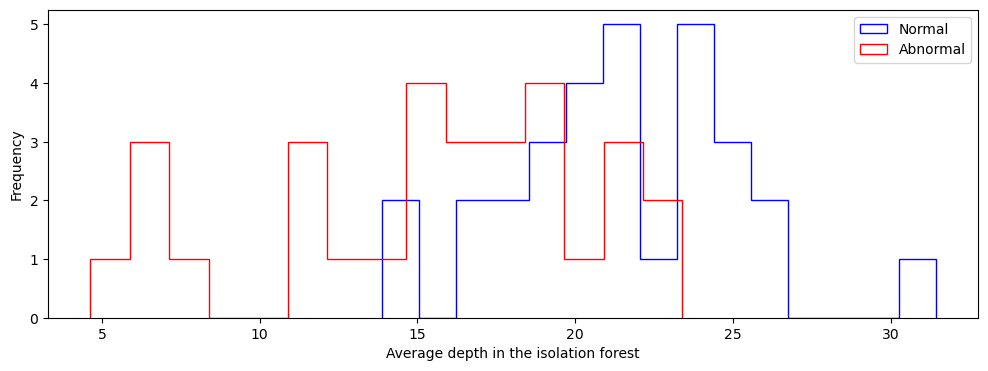

In [31]:
# LEAVE AS-IS

plt.figure(figsize=(12,4))
plt.hist(normal_depths, label='Normal', bins=15, density=False, histtype='step', color='blue')
plt.hist(abnormal_depths, label='Abnormal', bins=15, density=False, histtype='step', color='red')
plt.xlabel('Average depth in the isolation forest')
plt.ylabel('Frequency')
plt.legend()
plt.show()

We can clearly see that that normal observations have larger depths, with the majority of them concetrating around an average depth of 25. This confirms that normal points are harder to isolate in an isolation forest, i.e., they are isolated further from the root. On the other hand, abnormal observations have smaller depths, with most of the observations ranging between an average depth of 10 and 20. This suggests that outliers are easier to isolate in an isolation forest, i.e., they are identified closer to the root. It should be noted that the distributions show minimal oberlap, which indicates a good separation between normal and abnormal points.

## 3.2. Compute outlier scores and conclude

Next, we compute harmonic numbers.

In [35]:
# LEAVE AS-IS

# Source: https://stackoverflow.com/a/27683292/1235784

from numpy import euler_gamma
from scipy.special import digamma
def harmonic(s):
    return digamma(s + 1) + euler_gamma

The function below uses the *factory* design pattern to avoid computing *c(n)* every time the outlier score needs to be computed.

In [36]:
# LEAVE AS-IS

def outlier_score_factory():
    n = len(df.index)
    c_n = 2.0 * harmonic(n - 1.0) - (2.0 * (n-1)/n)
    return lambda d: 2.0**(-d/c_n)

outlier_score = outlier_score_factory()

normal_scores = [outlier_score(d) for d in normal_depths]
abnormal_scores = [outlier_score(d) for d in abnormal_depths]

Finally, we plot an histogram of outlier scores of normal and abnormal items.

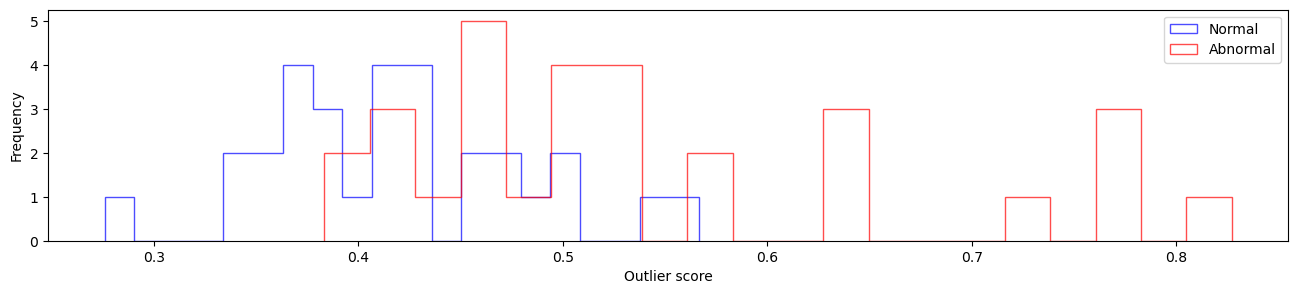

In [37]:
# LEAVE AS-IS

plt.figure(figsize=(16,3))

# Plot the two histograms; the parameter 'alpha' is the transparency of the bar
plt.hist(normal_scores, label='Normal', bins=20, density=False, histtype='step', color='blue', alpha=0.7)
plt.hist(abnormal_scores, label='Abnormal', bins=20, density=False, histtype='step', color='red', alpha=0.7)

# Draw the axis labels, legend, and display
plt.xlabel('Outlier score')
plt.ylabel('Frequency')
plt.legend()
plt.show()

Looking at the histogram, normal items have lower outlier scores than abnormal items. Indeed, the outlier score decreases exponentially as the depth increases. Hence, normal items (deeper in the tree) show smaller outlier scores than abnormal items (closer to the root). However, there is some overlap between both distributions. 

Next, we will use linear search to determine an optimal outlier score threshold based on `normal_scores` and `abnormal_scores` assuming every thyroid exam having *score <= threshold* will be classified as normal, and every thyroid exam with score > threshold will be classified as abnormal.

In [39]:
def compute_threshold(normal_scores, abnormal_scores):
    # Combine scores with labels (0=normal, 1=abnormal)
    scores = [(score, 0) for score in normal_scores] + [(score, 1) for score in abnormal_scores]
    scores.sort()  # Sort by score
    
    best_threshold = None
    min_misclassifications = float('inf')
    
    # Iterate through sorted scores to find the optimal threshold
    for i in range(1, len(scores)):
        # Potential threshold is the midpoint between consecutive scores
        threshold = (scores[i - 1][0] + scores[i][0]) / 2
        
        # Count misclassifications
        misclassified_normals = sum(1 for score, label in scores if score > threshold and label == 0)
        misclassified_abnormals = sum(1 for score, label in scores if score <= threshold and label == 1)
        total_misclassifications = misclassified_normals + misclassified_abnormals
        
        # Update the best threshold
        if total_misclassifications < min_misclassifications:
            min_misclassifications = total_misclassifications
            best_threshold = threshold

    return best_threshold

Finally, we will evaluate the threshold we have found. We know results will not be perfect as in this dataset there are some normal exams that look like abnormal and viceversa. To evaluate our threshold, we will compute the estimated **false positive rate** (the probability of saying that a thyroid is abnormal when it is normal), and **false negative rate** (the probability of saying that a thyroid is normal when it is abnormal).

In [43]:
def evaluate_threshold(normal_scores, abnormal_scores, threshold):
    # Classify normal and abnormal exams based on the threshold
    false_positives = sum(1 for score in normal_scores if score > threshold)
    false_negatives = sum(1 for score in abnormal_scores if score <= threshold)
    
    total_normals = len(normal_scores)
    total_abnormals = len(abnormal_scores)
    
    # Compute FPR and FNR
    fpr = false_positives / total_normals
    fnr = false_negatives / total_abnormals
    
    return fpr, fnr

In [44]:
optimal_threshold = compute_threshold(normal_scores, abnormal_scores)
fpr, fnr = evaluate_threshold(normal_scores, abnormal_scores, optimal_threshold)

print(f"Optimal Threshold: {optimal_threshold:.2f}")
print(f"False Positive Rate (FPR): {fpr:.2%}")
print(f"False Negative Rate (FNR): {fnr:.2%}")

Optimal Threshold: 0.43
False Positive Rate (FPR): 30.00%
False Negative Rate (FNR): 16.67%


According to our algorithm, the threshold of 0.43 achieves a balance between classifying normal and abnormal thyroid exams. However, the False Positive Rate (FPR) of 30% and the False Negative Rate (FNR) of 16.67% reflect the overlap in outlier scores between the two classes.

<font size="+2" color="#003300">I hereby declare that, except for the code provided by the course instructors, all of my code, report, and figures were produced by myself.</font>